In [1]:
#This project relies on two libraries which may not be installed on your computer.
#Install music21 via pip or whatever package manager you use.
#And make sure music_processors.py is in the same directory as this file.
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import music_processors as mp
from pathlib import Path
import music21 as m21 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

# Defining Paths for files

In [2]:
the_dir_lakh = 'Cleaned Lakh'
artist_names = os.listdir(the_dir_lakh)
artist_names.remove('.DS_Store')
artist_names.remove('.gitattributes')
artist_names.remove('LICENSE')
artist_names.remove('README.md')
artist_file_paths = [os.path.join(the_dir_lakh, n) for n in artist_names]
test = artist_file_paths[0]
song_names = [os.listdir(artist_file_paths[n]) for n in range(len(artist_file_paths))]
song_file_paths = [[os.path.join(artist_file_paths[k], n) for n in song_names[k]] for k in range(len(song_names))]


IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Genre Classification VIA Matching From Another Dataset

In [3]:
#dictionary comprehension of artist names and song names
artist_song_dict = {artist_names[n]: song_names[n] for n in range(len(artist_names))}
#create a pandas dictionary with a artist column, a song name column, and a file path column
ser_song_paths = pd.Series([song for artist in song_file_paths for song in artist])
ser_song_names = pd.Series([song for artist in song_names for song in artist])
ser_artist_names = pd.Series([artist for artist in artist_names for song in artist_song_dict[artist]])
df_song_paths = pd.DataFrame({'artist': ser_artist_names, 'song_name': ser_song_names, 'song_path': ser_song_paths})
df_song_paths['song_name'] = df_song_paths['song_name'].str[:-4]

#Removing underscores and capital letters from artist names and song names
df_song_paths['artist'] = df_song_paths['artist'].str.replace('_', ' ')
df_song_paths['artist'] = df_song_paths['artist'].str.title()
df_song_paths['song_name'] = df_song_paths['song_name'].str.replace('_', ' ')
df_song_paths['song_name'] = df_song_paths['song_name'].str.title()
df_song_paths.head()


,artist,song_name,song_path
0,.38 Special,Caught Up In You,Cleaned Lakh\.38 Special\Caught Up In You.mid
1,.38 Special,Fantasy Girl,Cleaned Lakh\.38 Special\Fantasy Girl.mid
2,"10,000 Maniacs",A Campfire Song,"Cleaned Lakh\10,000_Maniacs\A_Campfire_Song.mid"
3,101 Strings,Theme From The Godfather,Cleaned Lakh\101_Strings\Theme_From_The_Godfat...
4,10Cc,Dreadlock Holiday.1,Cleaned Lakh\10cc\Dreadlock_Holiday.1.mid


In [4]:
df_matched = df_song_paths.rename(columns={'artist': 'artist_name', 'song_name': 'title', 'song_path': 'file_path'})
df_matched['songartist'] = df_matched['artist_name'] + ' - ' + df_matched['title']
df_matched.head()


,artist_name,title,file_path,songartist
0,.38 Special,Caught Up In You,Cleaned Lakh\.38 Special\Caught Up In You.mid,.38 Special - Caught Up In You
1,.38 Special,Fantasy Girl,Cleaned Lakh\.38 Special\Fantasy Girl.mid,.38 Special - Fantasy Girl
2,"10,000 Maniacs",A Campfire Song,"Cleaned Lakh\10,000_Maniacs\A_Campfire_Song.mid","10,000 Maniacs - A Campfire Song"
3,101 Strings,Theme From The Godfather,Cleaned Lakh\101_Strings\Theme_From_The_Godfat...,101 Strings - Theme From The Godfather
4,10Cc,Dreadlock Holiday.1,Cleaned Lakh\10cc\Dreadlock_Holiday.1.mid,10Cc - Dreadlock Holiday.1


In [5]:
#same
df_song_paths['song_artist'] = df_song_paths['artist'] + ' - ' + df_song_paths['song_name']
df_song_paths.head()

,artist,song_name,song_path,song_artist
0,.38 Special,Caught Up In You,Cleaned Lakh\.38 Special\Caught Up In You.mid,.38 Special - Caught Up In You
1,.38 Special,Fantasy Girl,Cleaned Lakh\.38 Special\Fantasy Girl.mid,.38 Special - Fantasy Girl
2,"10,000 Maniacs",A Campfire Song,"Cleaned Lakh\10,000_Maniacs\A_Campfire_Song.mid","10,000 Maniacs - A Campfire Song"
3,101 Strings,Theme From The Godfather,Cleaned Lakh\101_Strings\Theme_From_The_Godfat...,101 Strings - Theme From The Godfather
4,10Cc,Dreadlock Holiday.1,Cleaned Lakh\10cc\Dreadlock_Holiday.1.mid,10Cc - Dreadlock Holiday.1


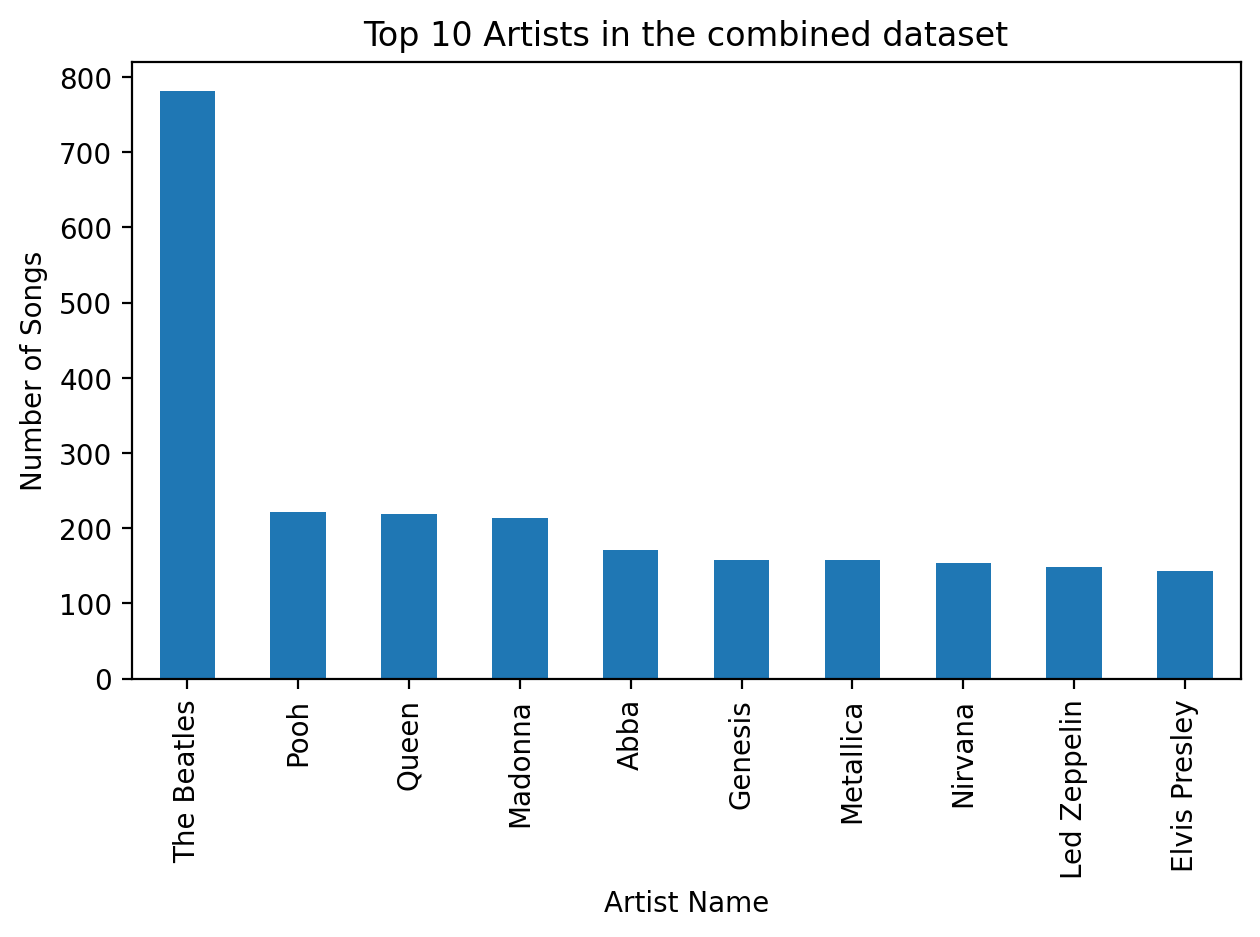

In [6]:
#hist with artist label on x axis and number of songs on y axis
df_matched['artist_name'].value_counts().head(10).plot(kind='bar',title='Top 10 Artists in the combined dataset',ylabel='Number of Songs',xlabel='Artist Name')
save_fig('Combined Dataset Top 10 Artists')

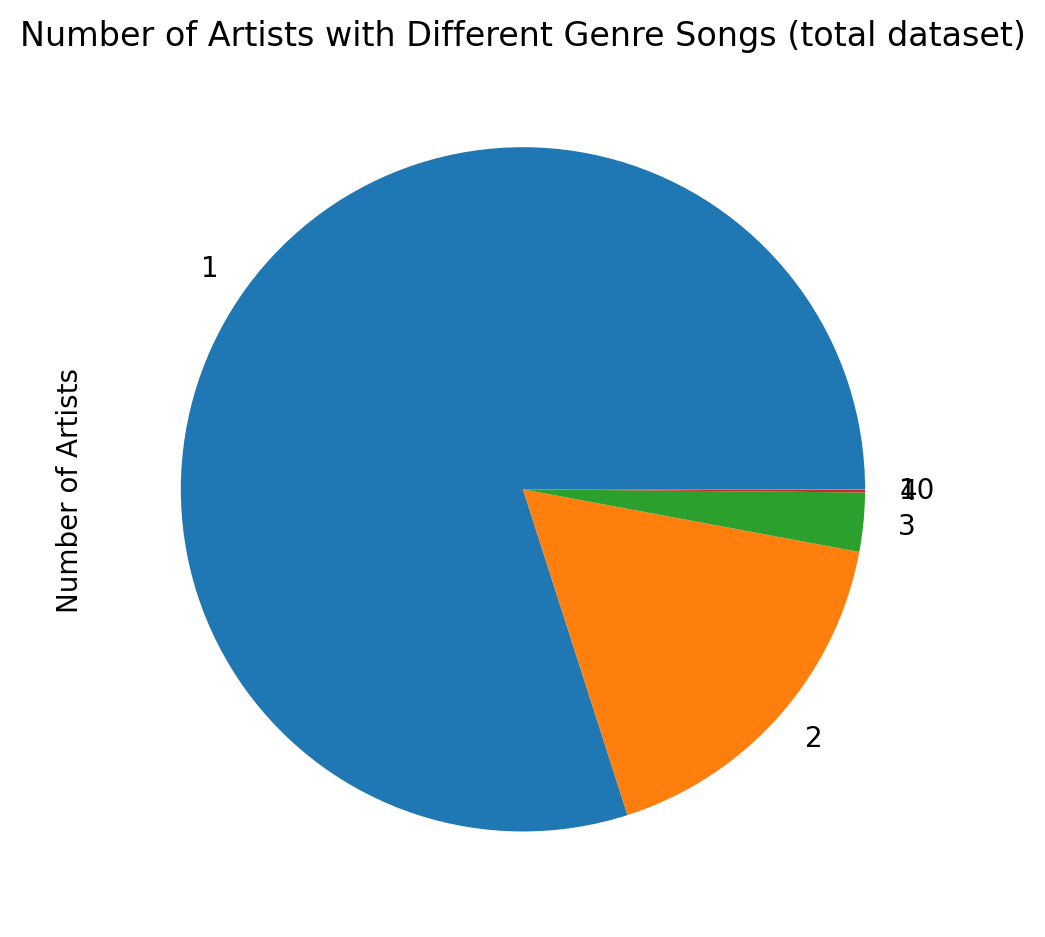

In [7]:
df_music_genre = pd.read_csv('music_genre.csv')
df_music_genre.drop(columns=['instance_id', 'duration_ms', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'danceability', 'popularity', 'obtained_date'], inplace=True)
df_music_genre.dropna(inplace=True)
df_music_genre.reset_index(inplace=True)
df_music_genre.drop(columns=['index'], inplace=True)
df_music_genre['artist_name'] = df_music_genre['artist_name'].str.title()
df_music_genre['artist_name'] = df_music_genre['artist_name'].str.replace('_', ' ')
df_music_genre['track_name'] = df_music_genre['track_name'].str.title()
df_music_genre['track_name'] = df_music_genre['track_name'].str.replace('_', ' ')

#plot the number of artists that have different genre songs
df_music_genre.groupby('artist_name')['music_genre'].nunique()
df_music_genre.groupby('artist_name')['music_genre'].nunique().value_counts().plot(kind='pie', title='Number of Artists with Different Genre Songs (total dataset)', ylabel='Number of Artists', xlabel='Number of Genres')
save_fig('Different Genre Artists Pie Chart')

In [8]:
#adding the genre column to the df_matched dataframe
#add the genre column to the df_matched dataframe where the artist name and song name match
df_matched_w_genre = df_matched[df_matched['artist_name'].isin(df_music_genre['artist_name'])]
df_matched_w_genre.reset_index(inplace=True)
df_matched_w_genre.drop(columns=['index'], inplace=True)
df_music_genre_matched = df_music_genre[df_music_genre['artist_name'].isin(df_matched['artist_name'])]
df_music_genre_matched.reset_index(inplace=True)
df_music_genre_matched.drop(columns=['index'], inplace=True)

C:\Users\hanse\AppData\Local\Temp\ipykernel_16444\1874103478.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matched_w_genre.drop(columns=['index'], inplace=True)
C:\Users\hanse\AppData\Local\Temp\ipykernel_16444\1874103478.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_music_genre_matched.drop(columns=['index'], inplace=True)


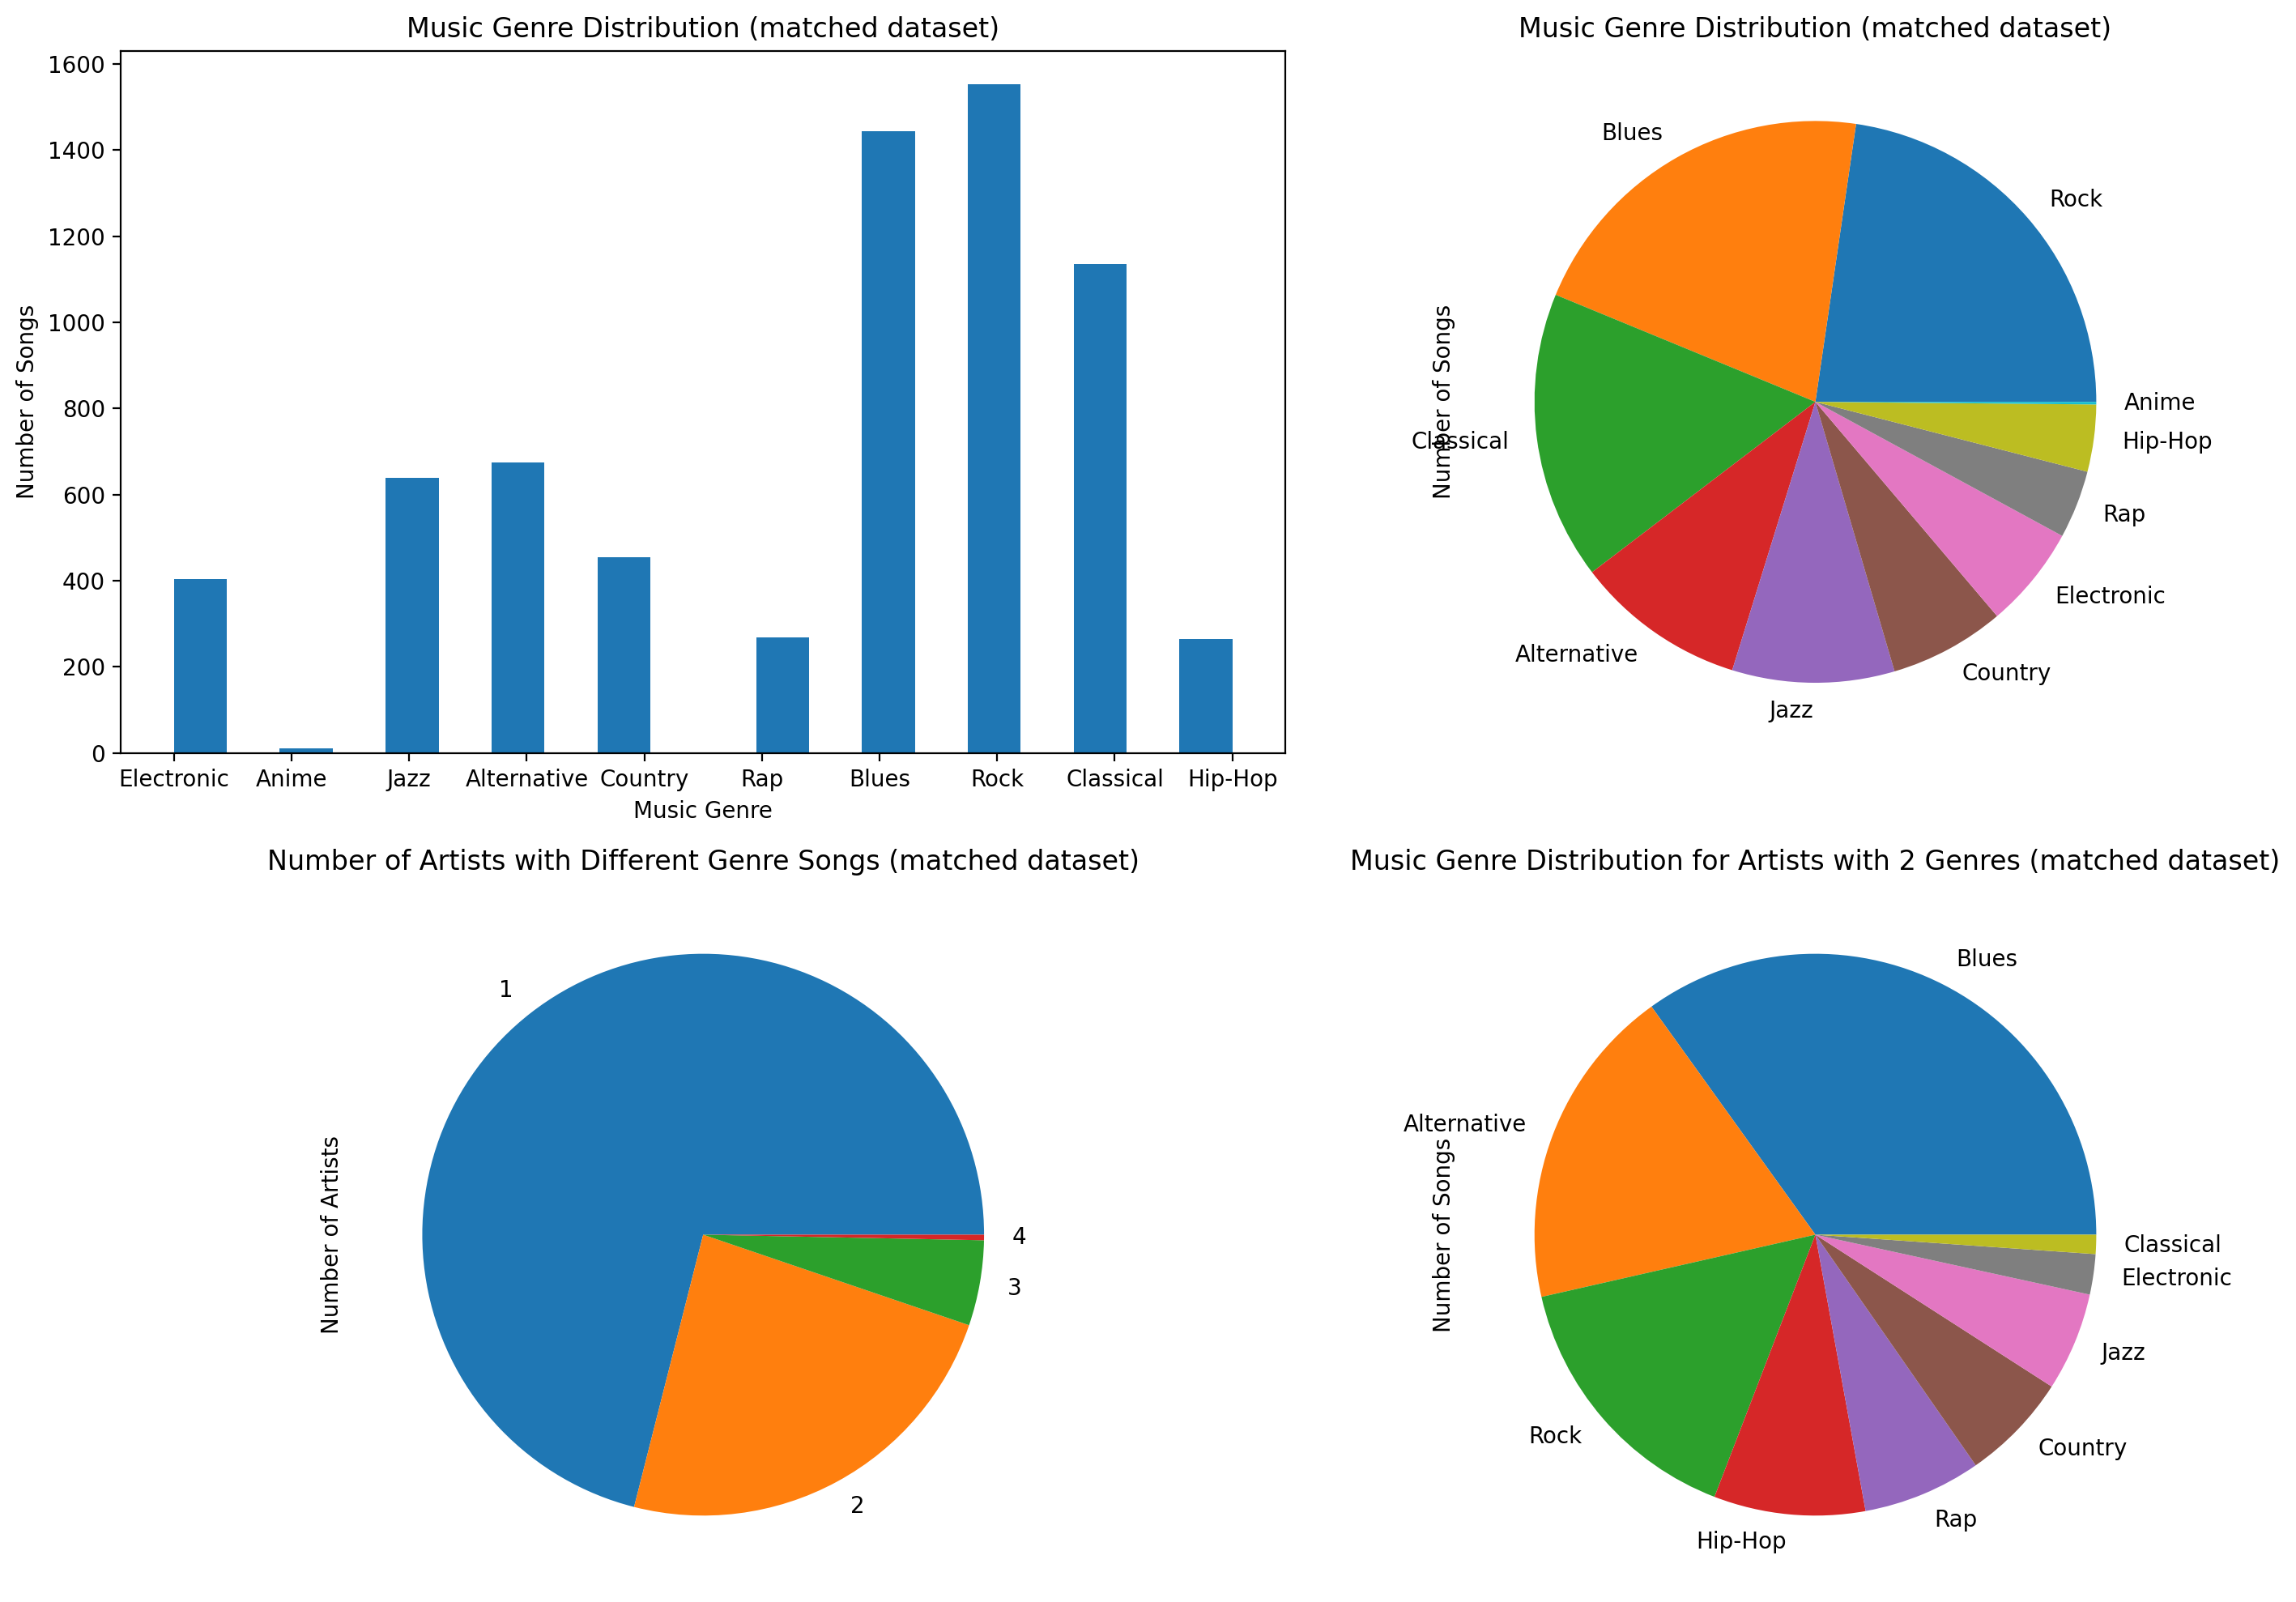

In [9]:
#create a 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].hist(df_music_genre_matched['music_genre'], bins=20)
axs[0, 0].set_title('Music Genre Distribution (matched dataset)')
axs[0, 0].set_xlabel('Music Genre')
axs[0, 0].set_ylabel('Number of Songs')
#create a pie chart of the music genre distribution in the [0,1] subplot
df_music_genre_matched['music_genre'].value_counts().plot(kind='pie', ax=axs[0, 1], title='Music Genre Distribution (matched dataset)', ylabel='Number of Songs', xlabel='Music Genre')
#plot the number of artists that have different genre songs
df_music_genre_matched.groupby('artist_name')['music_genre'].nunique().value_counts().plot(kind='pie', ax=axs[1, 0], title='Number of Artists with Different Genre Songs (matched dataset)', ylabel='Number of Artists', xlabel='Number of Genres')
#plot the genre distribution for artists that have 2 genres
df_music_genre_matched[df_music_genre_matched['artist_name'].isin(df_music_genre_matched.groupby('artist_name')['music_genre'].nunique().index[df_music_genre_matched.groupby('artist_name')['music_genre'].nunique() == 2])]['music_genre'].value_counts().plot(kind='pie', ax=axs[1, 1], title='Music Genre Distribution for Artists with 2 Genres (matched dataset)', ylabel='Number of Songs', xlabel='Music Genre')

save_fig('Music Genre Distribution Plots')

In [10]:
#more cleaning and preprocessing
#add label to the df_music_genre_matched dataframe with the number of genres that the artist has
df_music_genre_matched['num_genres'] = df_music_genre_matched.groupby('artist_name')['music_genre'].transform('nunique')
#if the artist has 2 genres, add a column with the first genre and a column with the second genre
df_music_genre_matched['first_genre'] = df_music_genre_matched.groupby('artist_name')['music_genre'].transform('first')
df_music_genre_matched['second_genre'] = df_music_genre_matched.groupby('artist_name')['music_genre'].transform('last')
#if the artist is in the df_matched_w_genre dataframe, add the two genres column to the df_matched_w_genre dataframe from df_music_genre_matched
#merging 
df_merged = df_matched_w_genre.merge(df_music_genre_matched[['artist_name', 'num_genres', 'first_genre', 'second_genre']], on='artist_name', how='left').drop_duplicates(subset=['songartist'])

C:\Users\hanse\AppData\Local\Temp\ipykernel_16444\414110964.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_music_genre_matched['num_genres'] = df_music_genre_matched.groupby('artist_name')['music_genre'].transform('nunique')
C:\Users\hanse\AppData\Local\Temp\ipykernel_16444\414110964.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_music_genre_matched['first_genre'] = df_music_genre_matched.groupby('artist_name')['music_genre'].transform('first')
C:\Users\hanse\AppData\Local\Temp\ipykernel_164

In [11]:
#columns_to_drop = ['artist_familiarity','release','track_id','song_id','artist_id','artist_mbid','duration','artist_familiarity','artist_hotttnesss','track_7digitalid','shs_perf','shs_work','year']
df_merged_cut = df_merged

#FIX FILE PATH
df_merged_cut.reset_index(inplace=True)
df_merged_cut.drop(columns=['index'], inplace=True)
df_merged_cut.head()


,artist_name,title,file_path,songartist,num_genres,first_genre,second_genre
0,"10,000 Maniacs",A Campfire Song,"Cleaned Lakh\10,000_Maniacs\A_Campfire_Song.mid","10,000 Maniacs - A Campfire Song",1,Rock,Rock
1,10Cc,Dreadlock Holiday.1,Cleaned Lakh\10cc\Dreadlock_Holiday.1.mid,10Cc - Dreadlock Holiday.1,1,Rock,Rock
2,10Cc,Dreadlock Holiday.2,Cleaned Lakh\10cc\Dreadlock_Holiday.2.mid,10Cc - Dreadlock Holiday.2,1,Rock,Rock
3,10Cc,Dreadlock Holiday.3,Cleaned Lakh\10cc\Dreadlock_Holiday.3.mid,10Cc - Dreadlock Holiday.3,1,Rock,Rock
4,10Cc,Dreadlock Holiday.4,Cleaned Lakh\10cc\Dreadlock_Holiday.4.mid,10Cc - Dreadlock Holiday.4,1,Rock,Rock


52% of the songs in the Cleaned Lakh dataset were matched with the Genre Classification dataset


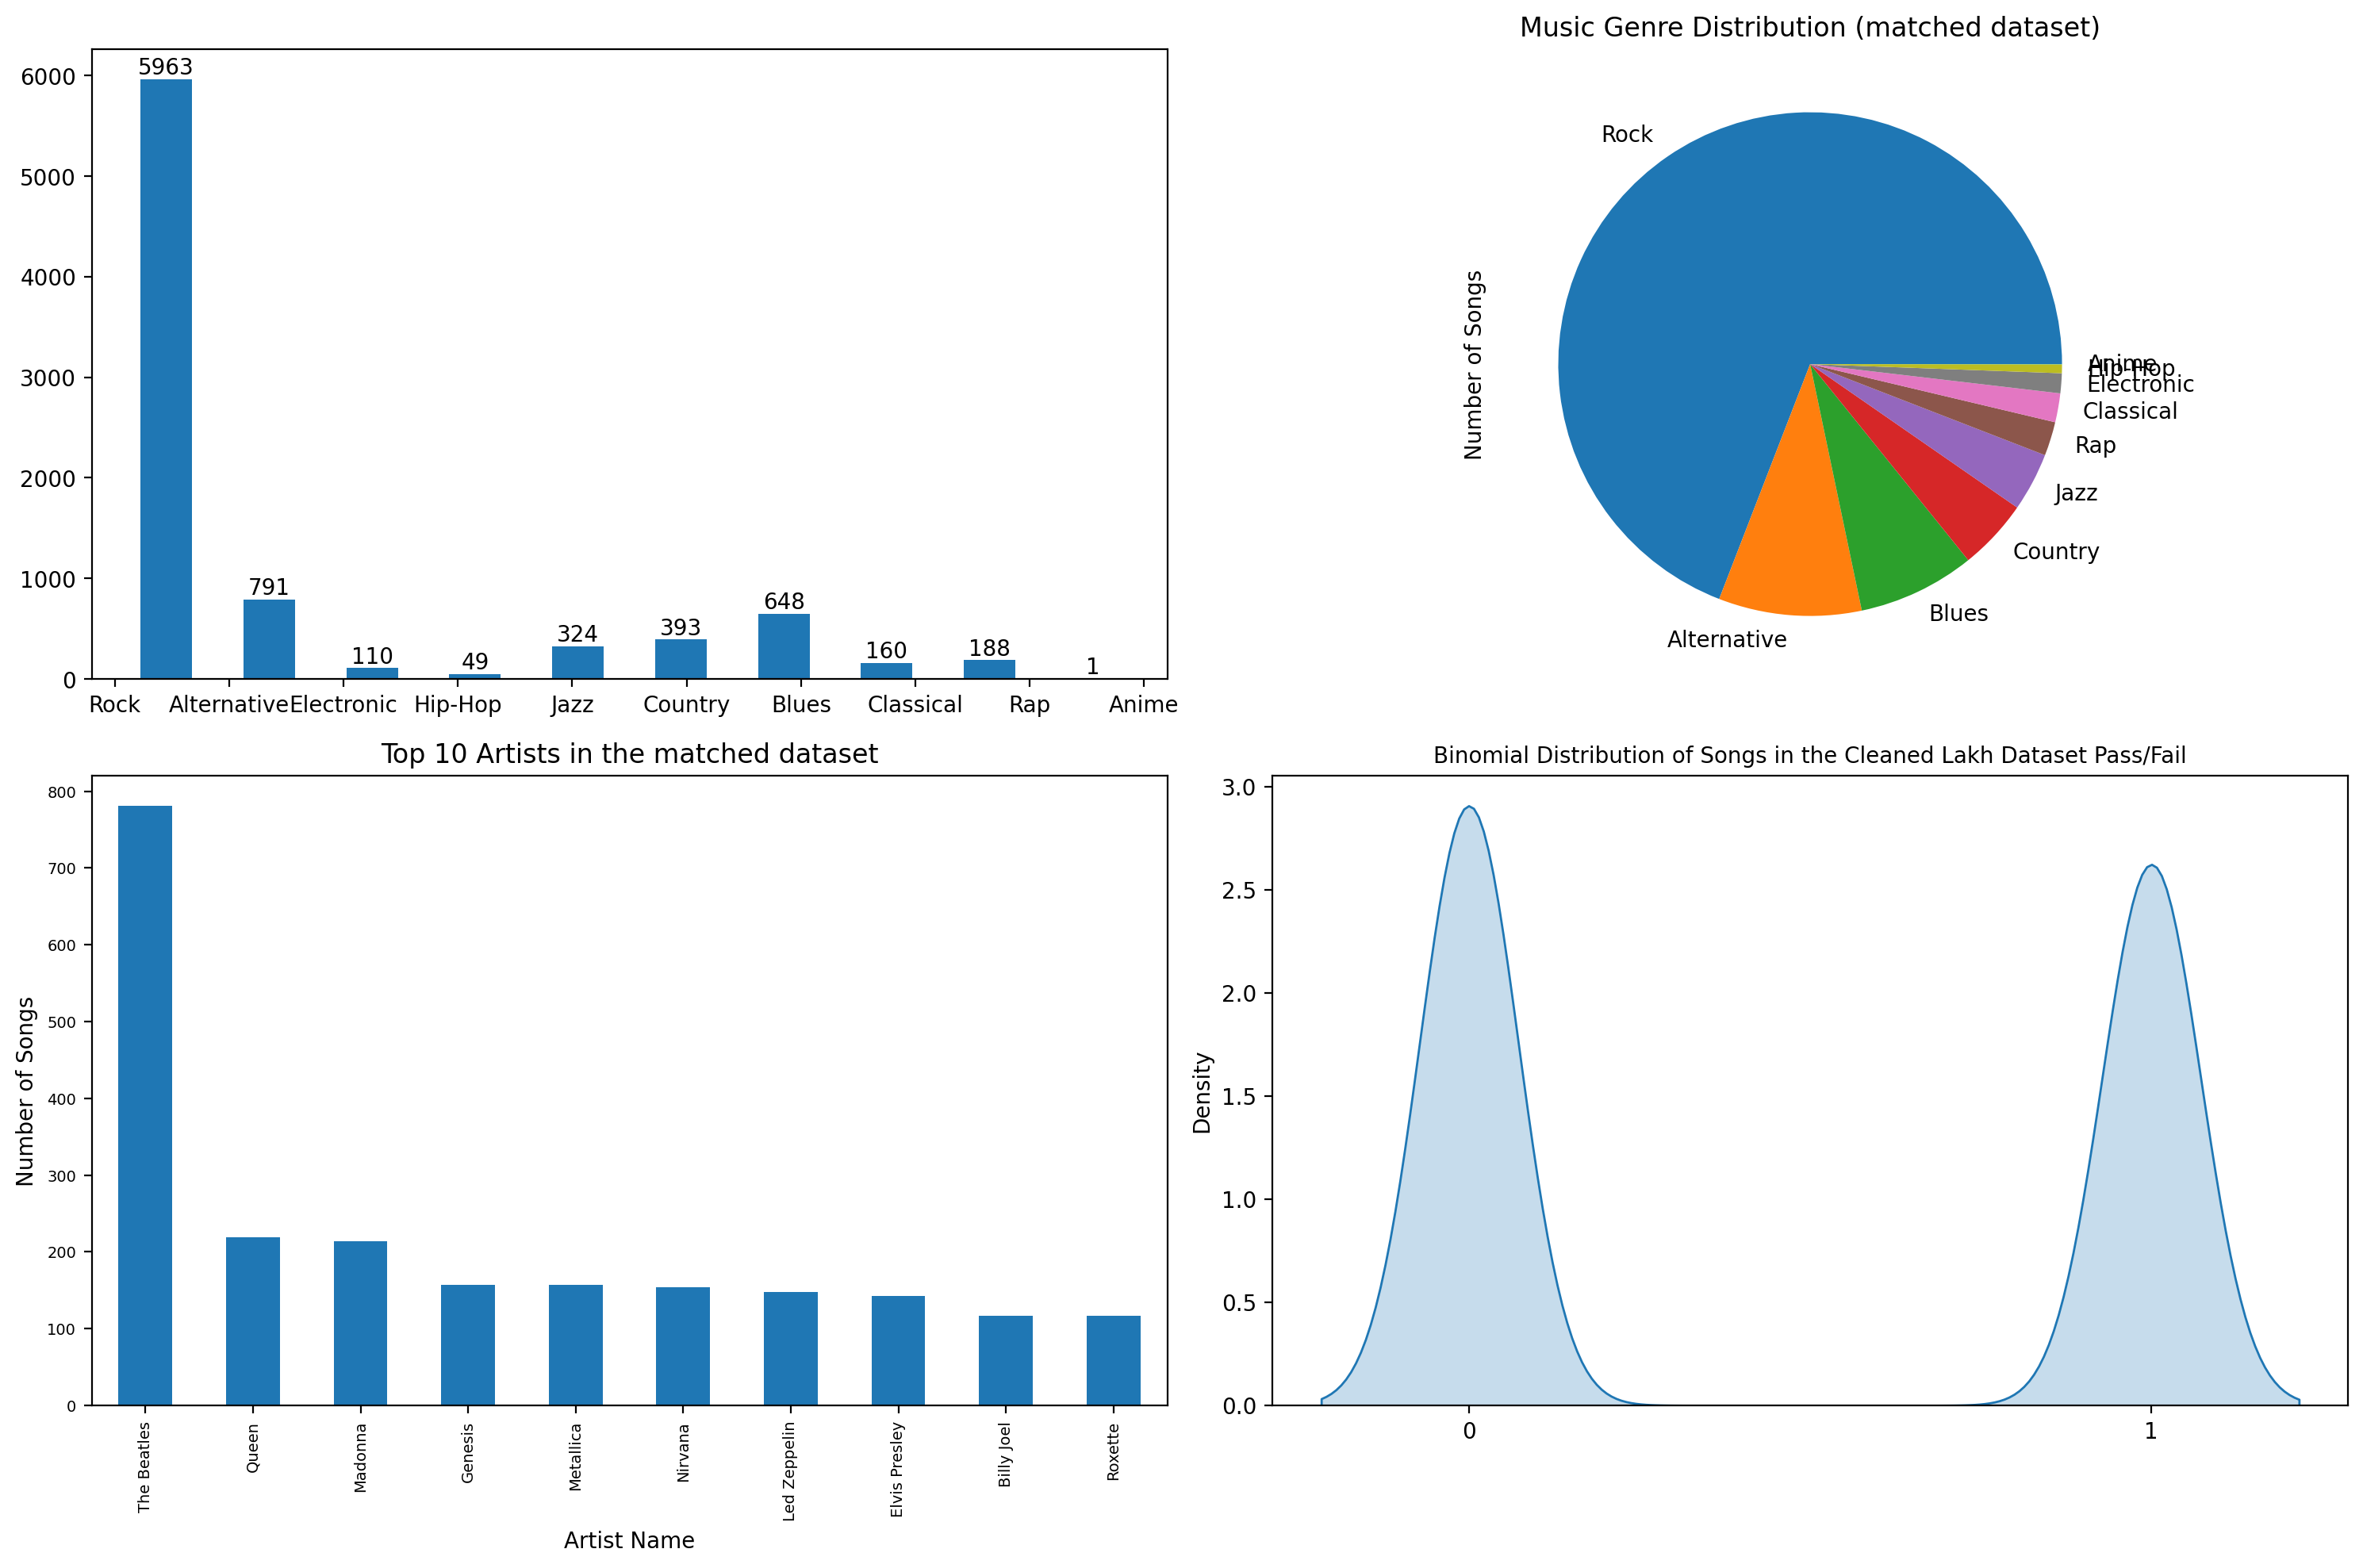

In [12]:
#Visualization with the data
#4 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].hist(df_merged_cut['first_genre'], bins=10,rwidth = 0.5)
axs[0,0].bar_label(axs[0,0].containers[0])
#plot the number of songs per artist with seaborn
df_merged_cut['artist_name'].value_counts().head(10).plot(kind='bar', ax=axs[1, 0], title='Top 10 Artists in the matched dataset', ylabel='Number of Songs', xlabel='Artist Name', fontsize= 7)
#plot the number of songs per genre with seaborn in a pie chart
df_merged_cut['first_genre'].value_counts().plot(kind='pie', ax=axs[0, 1], title='Music Genre Distribution (matched dataset)', ylabel='Number of Songs', xlabel='Music Genre')
#plot the count of df_songs_paths['artist'] vs df_merged_cut['artist_name'] with seaborn in a pie chart
print(f'{int(df_merged_cut["title"].unique().shape[0]/df_song_paths["song_name"].unique().shape[0]*100)}% of the songs in the Cleaned Lakh dataset were matched with the Genre Classification dataset')

x1 = np.zeros(df_merged_cut['title'].unique().shape[0])
x2 = np.ones(df_song_paths['song_name'].unique().shape[0] - len(x1))
data = np.concatenate((x1,x2), axis = 0)
#bimodal distribution of the song landing in the cleaned lakh dataset or not with title
sns.kdeplot(data, ax=axs[1, 1], fill=True, legend=True,)
axs[1, 1].set_title('Binomial Distribution of Songs in the Cleaned Lakh Dataset Pass/Fail', fontsize= 10)
axs[1, 1].set_xticks([0,1])
save_fig('Results of Matching Dataset')

# Working with the data

In [13]:
#Add full database with placeholder genre 
df_full = pd.concat((df_merged_cut,df_song_paths[df_song_paths['song_artist'].isin(df_merged_cut['songartist']) == False]))
df_full.fillna({'artist_name' : df_full['artist'], 'title' : df_full['song_name'], 'file_path': df_full['song_path'],'songartist' : df_full['song_artist'],'num_genres' : 1, 'first_genre' : 'Random', 'second_genre' : 'Random'},inplace=True)
df_full.reset_index(inplace=True)
df_full.drop(columns = ['artist','song_name','song_path','song_artist','index'],inplace= True)
df_full.tail()

,artist_name,title,file_path,songartist,num_genres,first_genre,second_genre
17226,Zucchero,Un Piccolo Aiuto Feat. Gerard Depardieu,Cleaned Lakh\Zucchero\Un_piccolo_aiuto_feat._G...,Zucchero - Un Piccolo Aiuto Feat. Gerard Depar...,1.0,Random,Random
17227,Zucchero,Voodoo Voodoo.1,Cleaned Lakh\Zucchero\Voodoo_voodoo.1.mid,Zucchero - Voodoo Voodoo.1,1.0,Random,Random
17228,Zucchero,Voodoo Voodoo.2,Cleaned Lakh\Zucchero\Voodoo_voodoo.2.mid,Zucchero - Voodoo Voodoo.2,1.0,Random,Random
17229,Zucchero,Voodoo Voodoo,Cleaned Lakh\Zucchero\Voodoo_voodoo.mid,Zucchero - Voodoo Voodoo,1.0,Random,Random
17230,Zucchero,You Make Me Feel Loved,Cleaned Lakh\Zucchero\You_Make_Me_Feel_Loved.mid,Zucchero - You Make Me Feel Loved,1.0,Random,Random


In [14]:
def pull_songs(artist_names=None, genres=None, df=df_full):
    if artist_names is None and genres is None:
        return df
    elif artist_names is not None and genres is None:
        return df[df['artist_name'].isin(artist_names)]
    elif artist_names is None and genres is not None:
        return df[df['first_genre'].isin(genres)]
    elif artist_names is not None and genres is not None:
        return df[df['artist_name'].isin(artist_names) & df['first_genre'].isin(genres)]

# Reading the Midi Files

In [15]:
#Function to process the dataframe and analyze the songs selected
def analyze_songs(song_selection):
    i = 1
    for val in song_selection['file_path']:
        try:
            score = mp.path_to_score(val)
        except:
            print(f'Error processing with {val}')
            continue

        note_list = mp.get_pitchnames(score)
        instrument_list = mp.get_instrument_names(score)
        the_key = mp.get_key(score)
        the_bpm = mp.get_tempo(score)
        the_duration = mp.get_song_length(score, the_bpm)

        song_selection.loc[song_selection['file_path'] == val,'Key'] = the_key
        song_selection.loc[song_selection['file_path'] == val,'Mode'] = mp.get_mode(the_key)
        song_selection.loc[song_selection['file_path'] == val,'Time Signature'] = mp.get_time_signature(score)
        song_selection.loc[song_selection['file_path'] == val,'BPM'] = the_bpm
        song_selection.loc[song_selection['file_path'] == val,'Duration'] = the_duration
        song_selection.loc[song_selection['file_path'] == val,'Tempo Changes'] = mp.get_number_of_tempo_changes(score)
        song_selection.loc[song_selection['file_path'] == val,'Ambitus'] = mp.get_ambitus(score)
        try:
            song_selection.loc[song_selection['file_path'] == val,'Instrument Names'] = ', '.join(instrument_list)
        except:
            instrument_list = ['Piano' , 'Guitar' , 'Vocal', 'Bass', 'Drums']
            song_selection.loc[song_selection['file_path'] == val,'Instrument Names'] = ', '.join(instrument_list)
        song_selection.loc[song_selection['file_path'] == val,'Has Drums'] = mp.has_drums(score)
        song_selection.loc[song_selection['file_path'] == val,'Pitch Names'] = ', '.join(note_list)
        song_selection.loc[song_selection['file_path'] == val,'Most Played Note'] = pd.Series(note_list).value_counts().keys()[0]
        song_selection.loc[song_selection['file_path'] == val,'Amount of Notes'] = int(len(note_list))
        song_selection.loc[song_selection['file_path'] == val,'Highest Note Repetition'] = int(pd.Series(note_list).value_counts().iloc[0]) / len(note_list)
        song_selection.loc[song_selection['file_path'] == val,'Crowdedness'] = mp.get_song_crowdedness(the_duration,len(note_list))
        song_selection.loc[song_selection['file_path'] == val,'Tonality Percentage'] = mp.get_tonality(note_list, mp.get_diatonic_notes(the_key))
        print(f'{i} / {len(song_selection)} Complete')
        i += 1


In [16]:
#Get list of artists that have more than 10 songs in the dataset so we can sample a large amount of songs from them
artist_list = df_full['artist_name'].value_counts()[(df_full['artist_name'].value_counts() >=10)].keys()
df_artist_list = df_full[df_full['artist_name'].isin(artist_list)]
artist_list_series = df_artist_list.groupby('first_genre')['artist_name'].unique()
artist_list_series

first_genre
Alternative    [Alanis Morissette, Alice In Chains, Bush, Col...
Blues          [Alice Cooper, Bad Company, Chris Rea, Chuck B...
Classical      [Andrea Bocelli, Claude Debussy, Ludwig Van Be...
Country        [Alabama, Alan Jackson, America, Bachman-Turne...
Electronic                       [Blur, Jamiroquai, The Prodigy]
Hip-Hop                                                   [Zero]
Jazz           [Chick Corea, George Benson, Nat King Cole, Os...
Random         [2 Unlimited, 883, Abba, Ace Of Base, Ac Dc, A...
Rap            [Britney Spears, Coolio, Fugees, Jennifer Lope...
Rock           [10Cc, A-Ha, Aerosmith, Air Supply, Amy Grant,...
Name: artist_name, dtype: object

In [17]:
#Get artist list from mp module
np.random.seed(42)
Alternative_artists, Blues_artists, Classical_artists, Country_artists, Electronic_artists, HipHop_artists, Jazz_artists, Random_artists, Rap_artists, Rock_artists = mp.get_artist_lists()

In [18]:
#Create dataframes of each artist in the lists
df_alternative = pull_songs(artist_names=Alternative_artists).groupby('artist_name', group_keys=False).apply(lambda group: group.sample(10))
df_blues = pull_songs(artist_names=Blues_artists).groupby('artist_name', group_keys=False).apply(lambda group: group.sample(10))
df_classical = pull_songs(artist_names=Classical_artists).groupby('artist_name', group_keys=False).apply(lambda group: group.sample(10))
df_country = pull_songs(artist_names=Country_artists).groupby('artist_name', group_keys=False).apply(lambda group: group.sample(10))
df_electronic = pull_songs(artist_names=Electronic_artists).groupby('artist_name', group_keys=False).apply(lambda group: group.sample(10))
df_hiphop = pull_songs(artist_names=HipHop_artists).groupby('artist_name', group_keys=False).apply(lambda group: group.sample(10))
df_jazz = pull_songs(artist_names=Jazz_artists).groupby('artist_name', group_keys=False).apply(lambda group: group.sample(10))
df_random = pull_songs(artist_names=Random_artists).groupby('artist_name', group_keys=False).apply(lambda group: group.sample(10))
df_rap = pull_songs(artist_names=Rap_artists).groupby('artist_name', group_keys=False).apply(lambda group: group.sample(10))
df_rock = pull_songs(artist_names=Rock_artists).groupby('artist_name', group_keys=False).apply(lambda group: group.sample(10))

In [19]:
def custom_float_conversion(value):
    try:
        return float(value)
    except ValueError:
        if '/' in value:
            numerator, denominator = map(float, value.split('/'))
            return numerator / denominator
        else:
            return np.nan

#Try to read the analyzed dataset from the files, if it doesn't exist, create it and save it to the files
try: 
    df_final = pd.read_csv('Analyzed Lakh Dataset.csv')
    mapping = mp.get_artist_mapping()
    df_final.loc[df_final['artist_name'].isin(mapping.keys()), ['first_genre','second_genre']] = df_final['artist_name'].map(mapping)
except:
    print('Dataset not found in files, creating new dataset (Warning: This can take a few hours)')
    analyze_songs(df_alternative)
    analyze_songs(df_blues)
    analyze_songs(df_classical)
    analyze_songs(df_country)
    analyze_songs(df_electronic)
    analyze_songs(df_hiphop)
    analyze_songs(df_jazz)
    analyze_songs(df_random)
    analyze_songs(df_rap)
    analyze_songs(df_rock)

    #combine all dataframes into one
    df_final = pd.concat([df_alternative,df_blues,df_classical,df_country,df_electronic,df_hiphop,df_jazz,df_random,df_rap,df_rock])
    df_final.drop([4542,4653,3199],inplace=True) #replacing the uncovertible songs with songs from the same artist
    df_addition = df_full.iloc[[4530, 4657, 3202]]
    analyze_songs(df_addition)
    df_final = pd.concat([df_final,df_addition])

    df_final.to_csv('Analyzed Lakh Dataset.csv')
    df_final = pd.read_csv('Analyzed Lakh Dataset.csv')
    mapping = mp.get_artist_mapping()
    df_final.loc[df_final['artist_name'].isin(mapping.keys()), ['first_genre','second_genre']] = df_final['artist_name'].map(mapping)
    
df_final.drop(columns=['Unnamed: 0'],inplace=True)
df_final['Crowdedness'] = df_final['Crowdedness'].apply(custom_float_conversion)
df_final['Duration'] = df_final['Duration'].apply(custom_float_conversion)


### Column Explanation

In [20]:
df_final.head()
#artist_name : name of the artist
#title : name of the song
#file_path : path to the midi file
#songartist : artist_name + title
#num_genres : number of genres that the artist has
#first_genre : first genre of the artist
#second_genre : second genre of the artist

#These columns were what we created using our music_processors module
#Key : key of the song
#Mode : major or minor
#Time Signature : time signature of the song
#BPM : beats per minute
#Duration : duration of the song in minutes (due to the library used this can be off by a bit)
#Tempo Changes : number of tempo changes in the song
#Ambitus : The highest note's pitch - the lowest note's pitch
#Instrument Names : The instruments used in the song
#Has Drums : Whether the song has drums or not
#Pitch Names : The full list of pitches that are played in the song
#Most Played Note : The most played note in the song
#Amount of Notes : The amount of notes in the song
#Highest Note Repetition : The highest note's repetition proportion in the song
#Crowdedness : The crowdedness of the song (how busy it sounds)
#Tonality Percentage : The percentage of the song that is in the key of the song

,artist_name,title,file_path,songartist,num_genres,first_genre,second_genre,Key,Mode,Time Signature,...,Tempo Changes,Ambitus,Instrument Names,Has Drums,Pitch Names,Most Played Note,Amount of Notes,Highest Note Repetition,Crowdedness,Tonality Percentage
0,Foo Fighters,Big Me.1,Cleaned Lakh\Foo_Fighters\Big_Me.1.mid,Foo Fighters - Big Me.1,2.0,Alternative,Rock,C,Major,4/4,...,1.0,48.0,"Guitar 1, Acoustic Guitar",True,"C, E, G, C, G, E, C, C, C, E, G, G, C, C, E, G...",C,4543.0,0.270526,2187.988971,0.981730
1,Foo Fighters,My Poor Brain,Cleaned Lakh\Foo_Fighters\My_Poor_Brain.mid,Foo Fighters - My Poor Brain,2.0,Alternative,Rock,F#,Major,2/4,...,0.0,47.0,"Piano, Guitar, Vocal, Bass, Drums",True,"F, F, C#, C#, C#, C#, C#, E-, E-, F, F, C#, C#...",C#,4410.0,0.266893,1316.729858,0.823810
2,Foo Fighters,Ill Stick Around,Cleaned Lakh\Foo_Fighters\Ill_Stick_Around.mid,Foo Fighters - Ill Stick Around,2.0,Alternative,Rock,g,minor,4/4,...,0.0,54.0,"guitar 1, Electric Guitar",True,"G, D, D, G, E-, B-, E-, B-, E-, B-, B-, F, C, ...",G,6321.0,0.234931,1677.496154,0.887518
3,Foo Fighters,Big Me.2,Cleaned Lakh\Foo_Fighters\Big_Me.2.mid,Foo Fighters - Big Me.2,2.0,Alternative,Rock,C,Major,4/4,...,0.0,39.0,"Guitar 1, Guitar 1, Electric Guitar",False,"C, E, G, C, C, E, G, C, C, E, G, C, G, C, E, G...",C,4286.0,0.262249,1985.426471,0.980635
4,Foo Fighters,Requiem,Cleaned Lakh\Foo_Fighters\Requiem.mid,Foo Fighters - Requiem,2.0,Alternative,Rock,D,Major,4/4,...,0.0,21.0,Electric Guitar,True,"A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A...",A,1668.0,0.564149,361.683673,0.981415


# Model Creation and Exploration

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


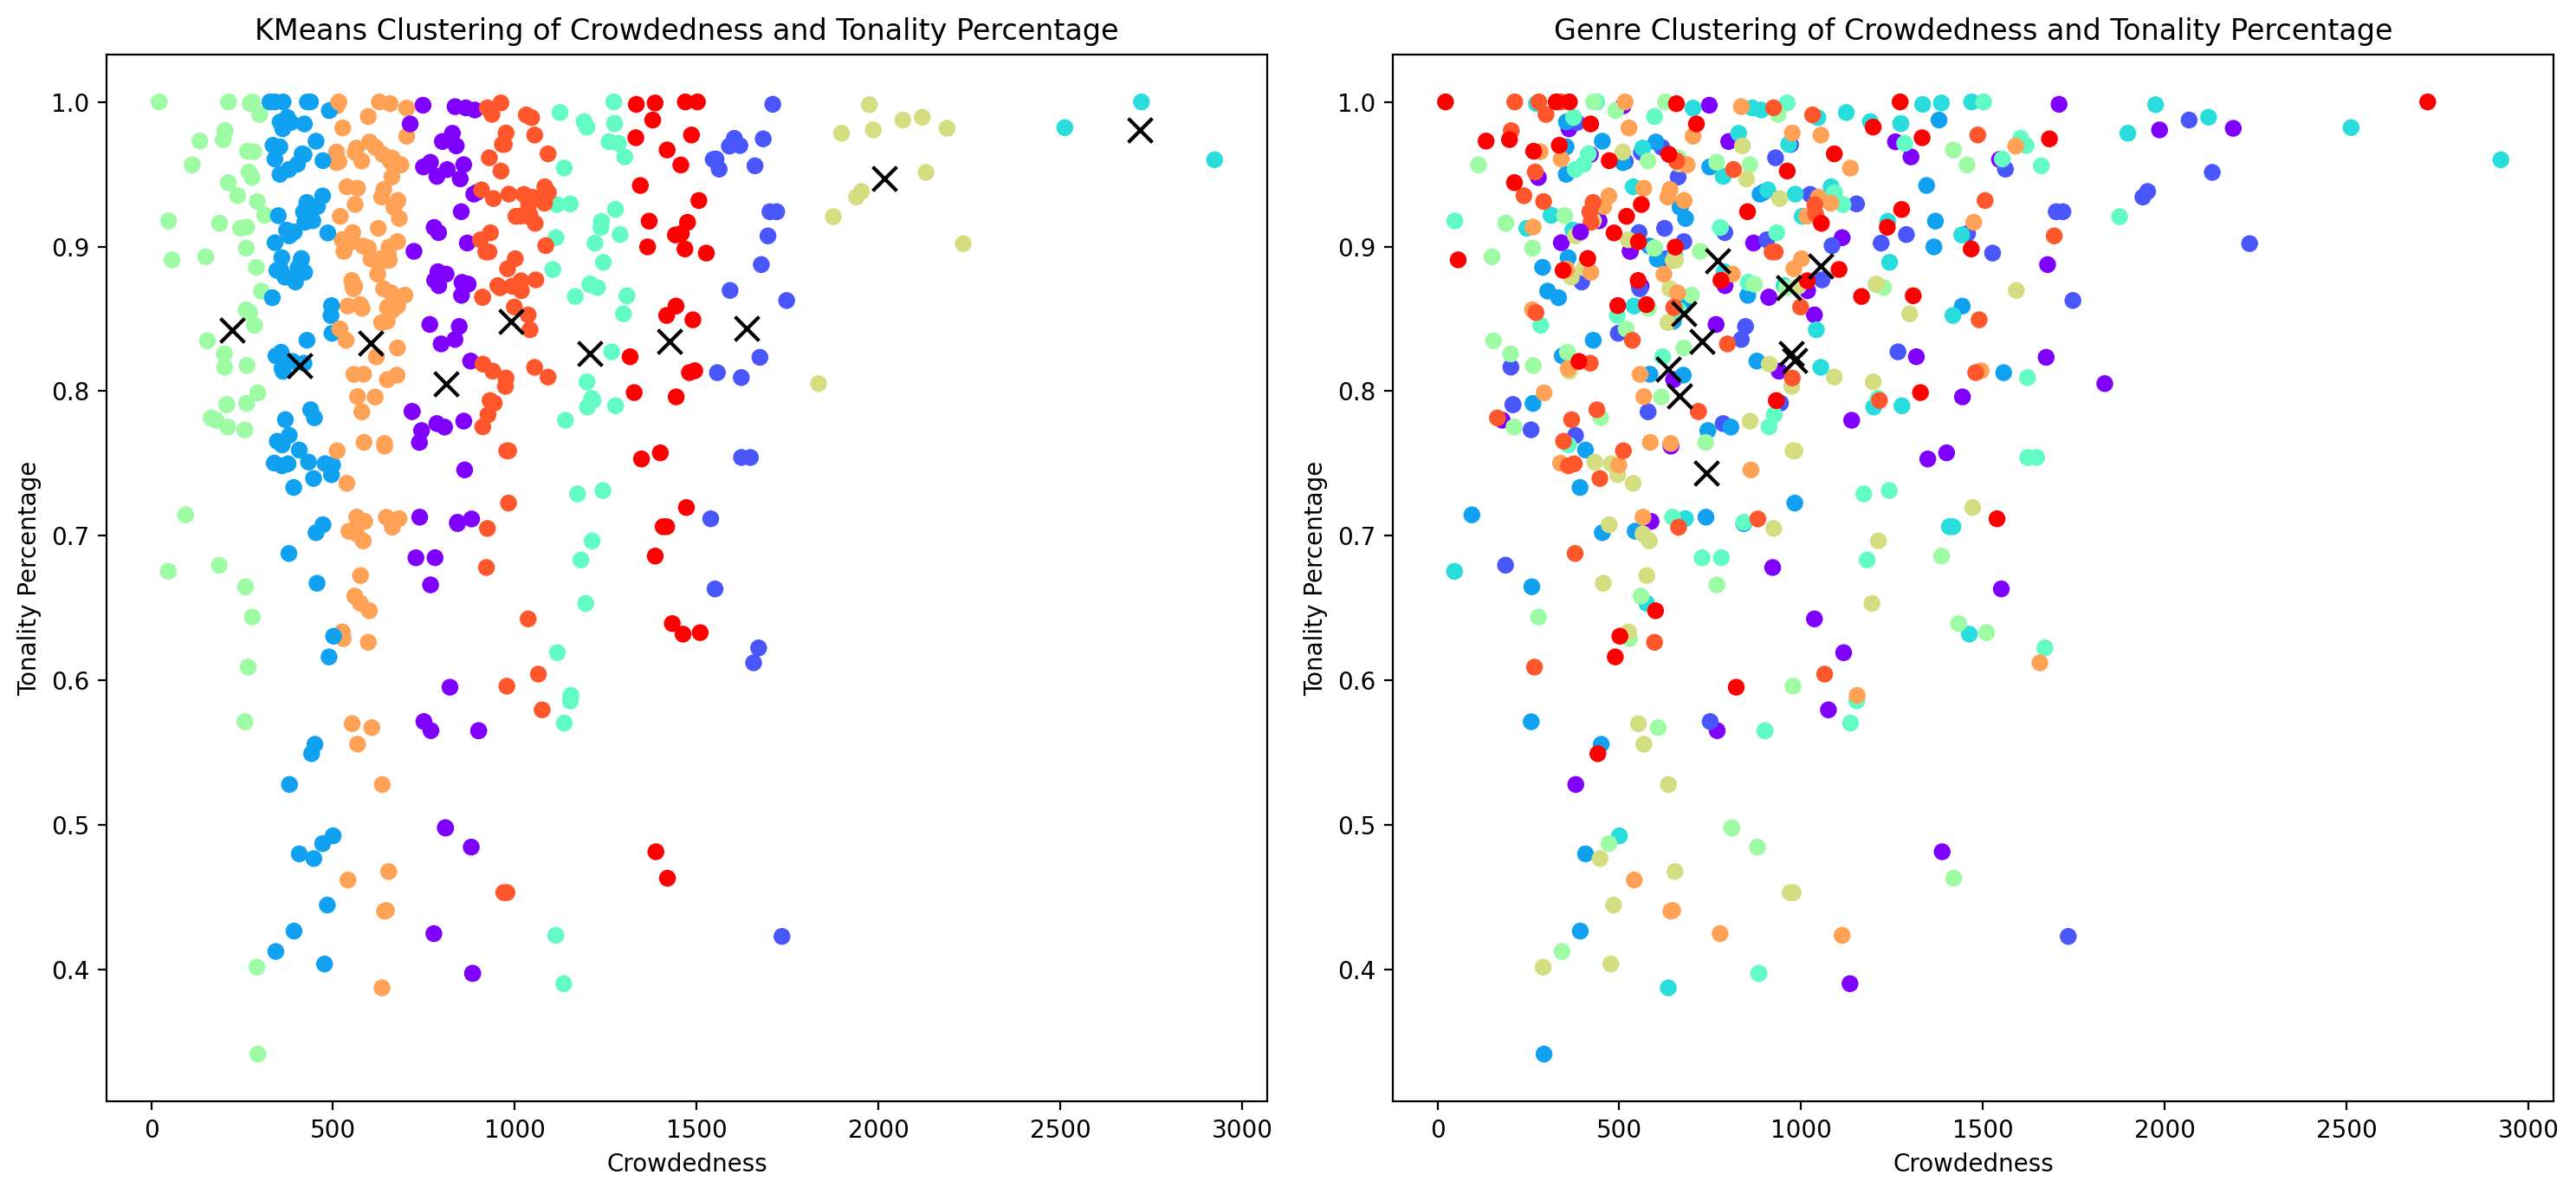

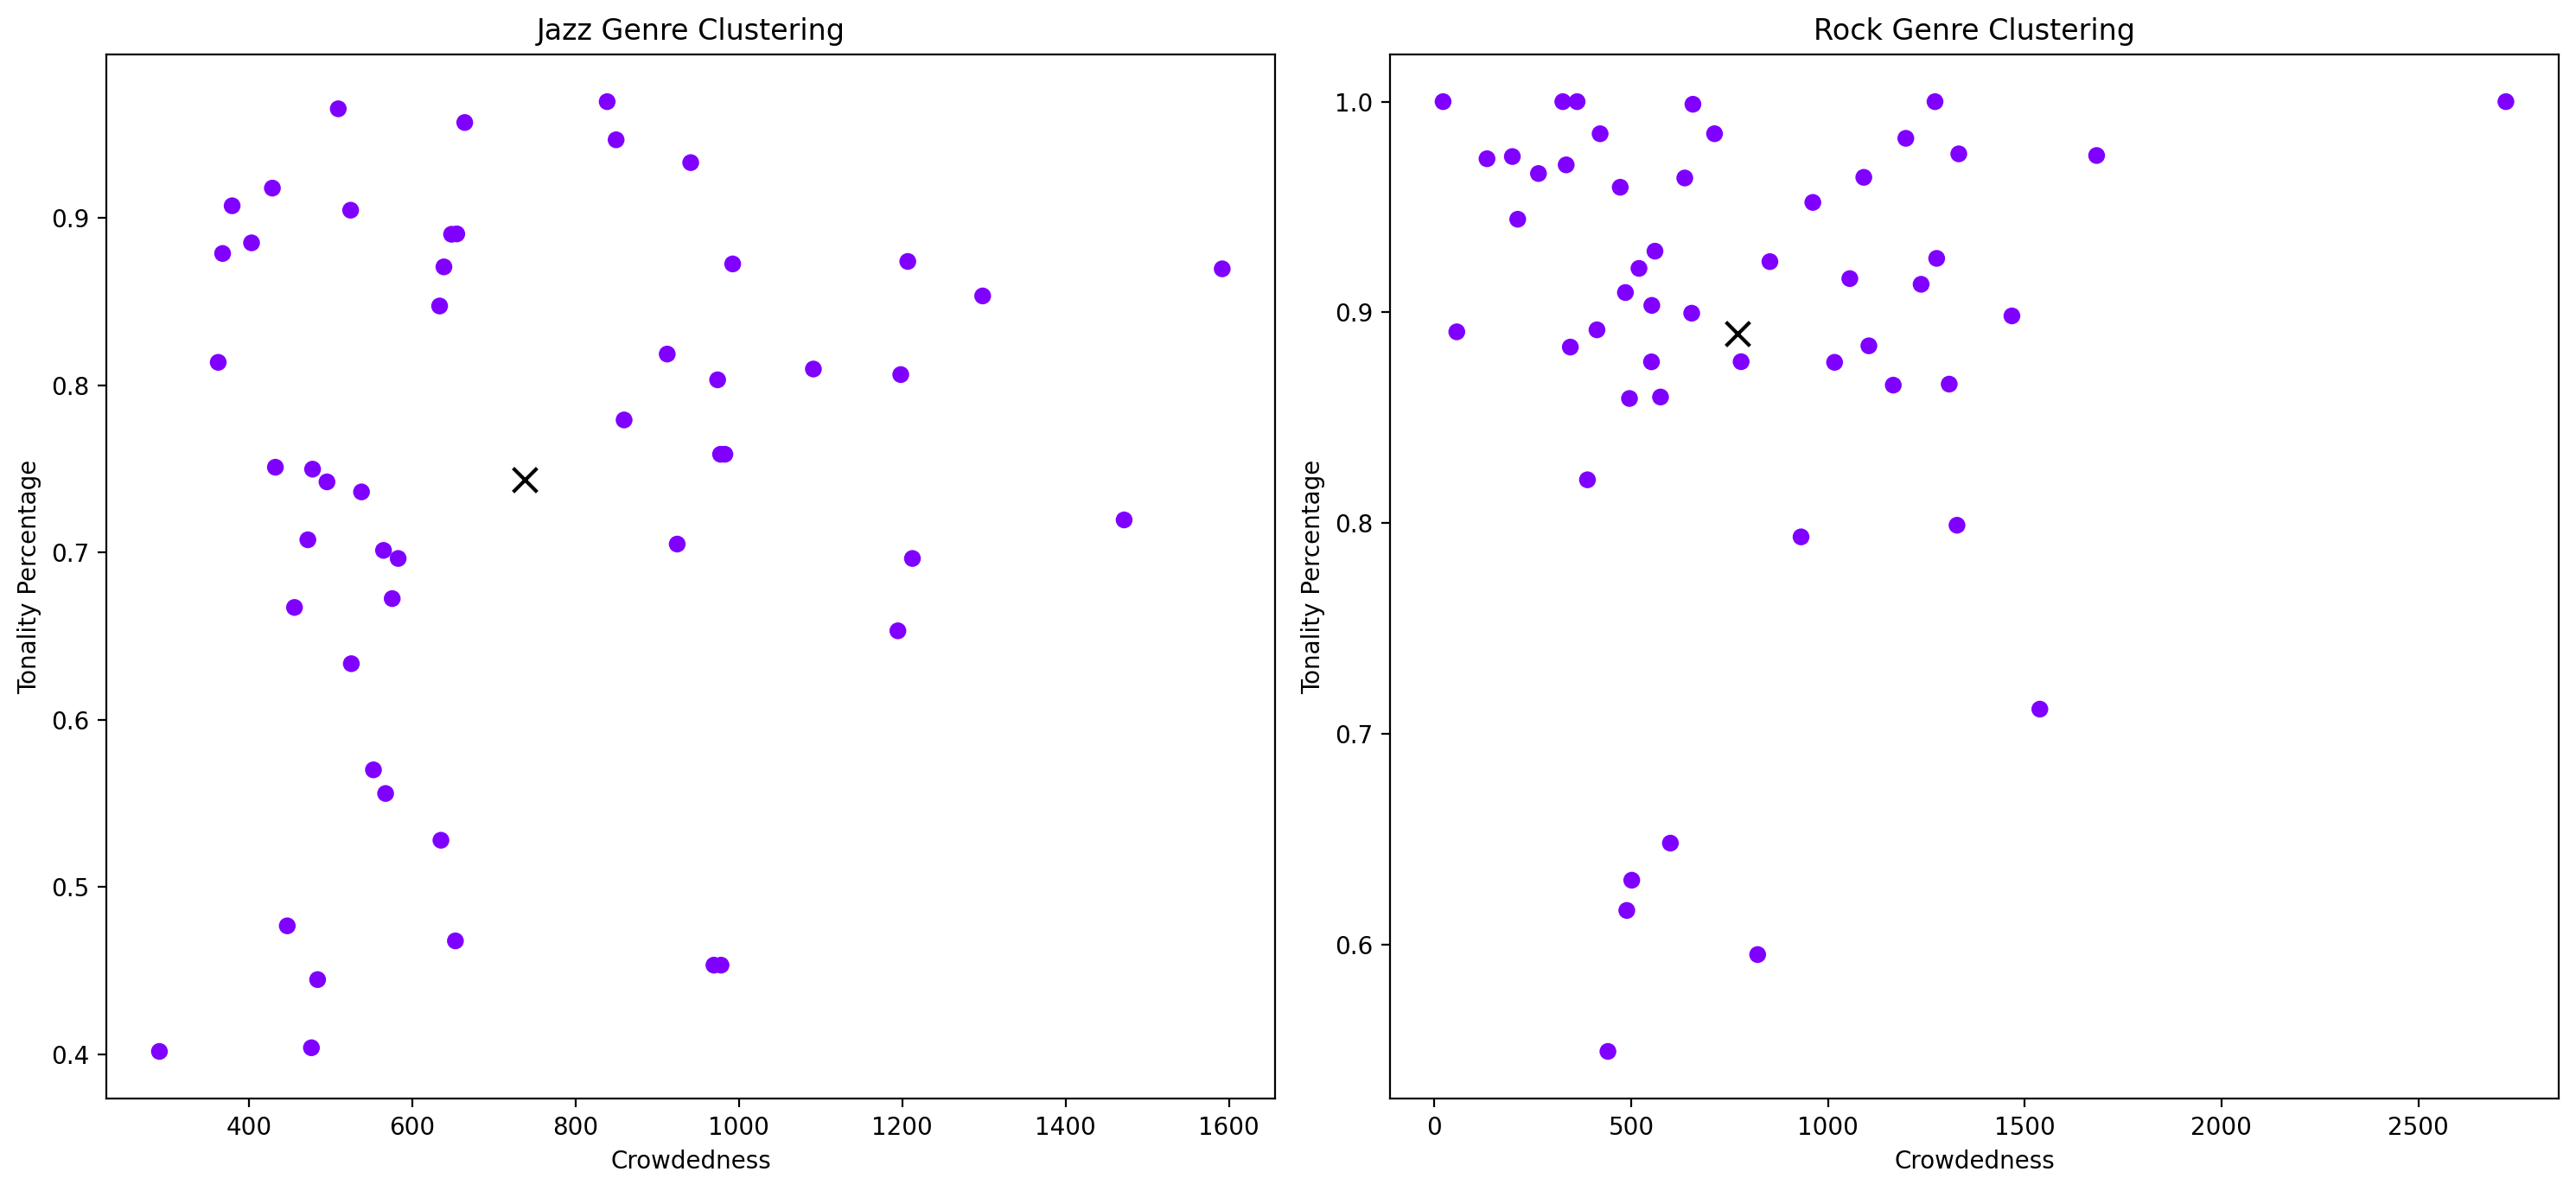

In [32]:
the_kmm = KMeans(n_clusters=10, random_state=42)
the_kmm.fit(df_final[['Crowdedness','Tonality Percentage']])
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].scatter(df_final['Crowdedness'], df_final['Tonality Percentage'], c=the_kmm.labels_, cmap = 'rainbow')
axs[0].scatter(the_kmm.cluster_centers_[:,0], the_kmm.cluster_centers_[:,1], c='black', marker='x', s=100)
axs[0].set_title('KMeans Clustering of Crowdedness and Tonality Percentage')
axs[0].set_xlabel('Crowdedness')
axs[0].set_ylabel('Tonality Percentage')

axs[1].scatter(df_final['Crowdedness'], df_final['Tonality Percentage'], c=df_final['first_genre'].astype('category').cat.codes,cmap = 'rainbow')
piv = df_final.pivot_table(index='first_genre', values=['Crowdedness', 'Tonality Percentage'], aggfunc='mean')
axs[1].scatter(piv['Crowdedness'], piv['Tonality Percentage'], c='black', marker='x', s=100)
axs[1].set_title('Genre Clustering of Crowdedness and Tonality Percentage')
axs[1].set_xlabel('Crowdedness')
axs[1].set_ylabel('Tonality Percentage')

save_fig('Clusters')

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].scatter(df_final[df_final['first_genre'] == 'Jazz']['Crowdedness'], df_final[df_final['first_genre'] == 'Jazz']['Tonality Percentage'], c=df_final[df_final['first_genre'] == 'Jazz']['first_genre'].astype('category').cat.codes,cmap = 'rainbow')
piv = df_final[df_final['first_genre'] == 'Jazz'].pivot_table(index='first_genre', values=['Crowdedness', 'Tonality Percentage'], aggfunc='mean')
axs[0].scatter(piv['Crowdedness'], piv['Tonality Percentage'], c='black', marker='x', s=100)

axs[0].set_title('Jazz Genre Clustering')
axs[0].set_xlabel('Crowdedness')
axs[0].set_ylabel('Tonality Percentage')

axs[1].scatter(df_final[df_final['first_genre'] == 'Rock']['Crowdedness'], df_final[df_final['first_genre'] == 'Rock']['Tonality Percentage'], c=df_final[df_final['first_genre'] == 'Rock']['first_genre'].astype('category').cat.codes,cmap = 'rainbow')
#plot the mean of the crowdedness and tonality percentage for the rock genre
piv = df_final[df_final['first_genre'] == 'Rock'].pivot_table(index='first_genre', values=['Crowdedness', 'Tonality Percentage'], aggfunc='mean')
axs[1].scatter(piv['Crowdedness'], piv['Tonality Percentage'], c='black', marker='x', s=100)

axs[1].set_title('Rock Genre Clustering')
axs[1].set_xlabel('Crowdedness')
axs[1].set_ylabel('Tonality Percentage')


save_fig('Jazz and Rock Clusters')


In [22]:
num_attribs = ['BPM', 'Duration', 'Tempo Changes', 'Amount of Notes', 'Highest Note Repetition', 'Crowdedness', 'Tonality Percentage']
cat_attribs = ['Key', 'Mode', 'Time Signature', 'Instrument Names', 'Has Drums', 'Most Played Note']

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters = 10, gamma = 1.0, random_state = 42):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X,sample_weight=sample_weight)
        return self
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names(self, names = None):
        return [f'Cluster {i} proximity' for i in range(self.n_clusters)]

clu_sim = ClusterSimilarity(n_clusters=10, gamma = 1, random_state=42)
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(sparse=False))
])

preprocessing = ColumnTransformer([
    ('clu_sim', clu_sim, ['Crowdedness', 'Tonality Percentage']),
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])
y = df_final['first_genre']
X = df_final.drop(columns=['file_path','songartist','artist_name','title','first_genre','second_genre'])
preprocessing.fit(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_prepared = preprocessing.transform(X_train)
X_test_prepared = preprocessing.transform(X_test)
X_prepared = preprocessing.transform(X)


C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [23]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_prepared, y_train)

rand_for = RandomForestClassifier(random_state=42)
rand_for.fit(X_train_prepared, y_train)

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train_prepared, y_train)

log_reg_score = cross_val_score(log_reg, X_train_prepared, y_train, cv=5).mean()
forest_score = cross_val_score(rand_for, X_train_prepared, y_train, cv=5).mean()
svm_score = cross_val_score(svm_clf, X_train_prepared, y_train, cv=5).mean()

log_reg_score, forest_score, svm_score

(0.32533333333333336, 0.3946666666666666, 0.3546666666666667)

In [24]:
#Random Forest wins and randomized search was done to find best hp max_features = 2, n_estimators = 75
forest_clf = RandomForestClassifier(max_features=2, n_estimators=75, random_state=42)
y_full_pred = cross_val_predict(forest_clf,X_prepared, y, cv=5)
conf_mx = confusion_matrix(y, y_full_pred)
print('Using the full dataset: ')
print(f'Precision: {precision_score(y, y_full_pred, average="micro")}')
print(f'Recall: {recall_score(y, y_full_pred, average="macro")}')
print(f'F1: {f1_score(y, y_full_pred, average="weighted")}')

Using the full dataset: 
Precision: 0.196
Recall: 0.196
F1: 0.18922770113329015


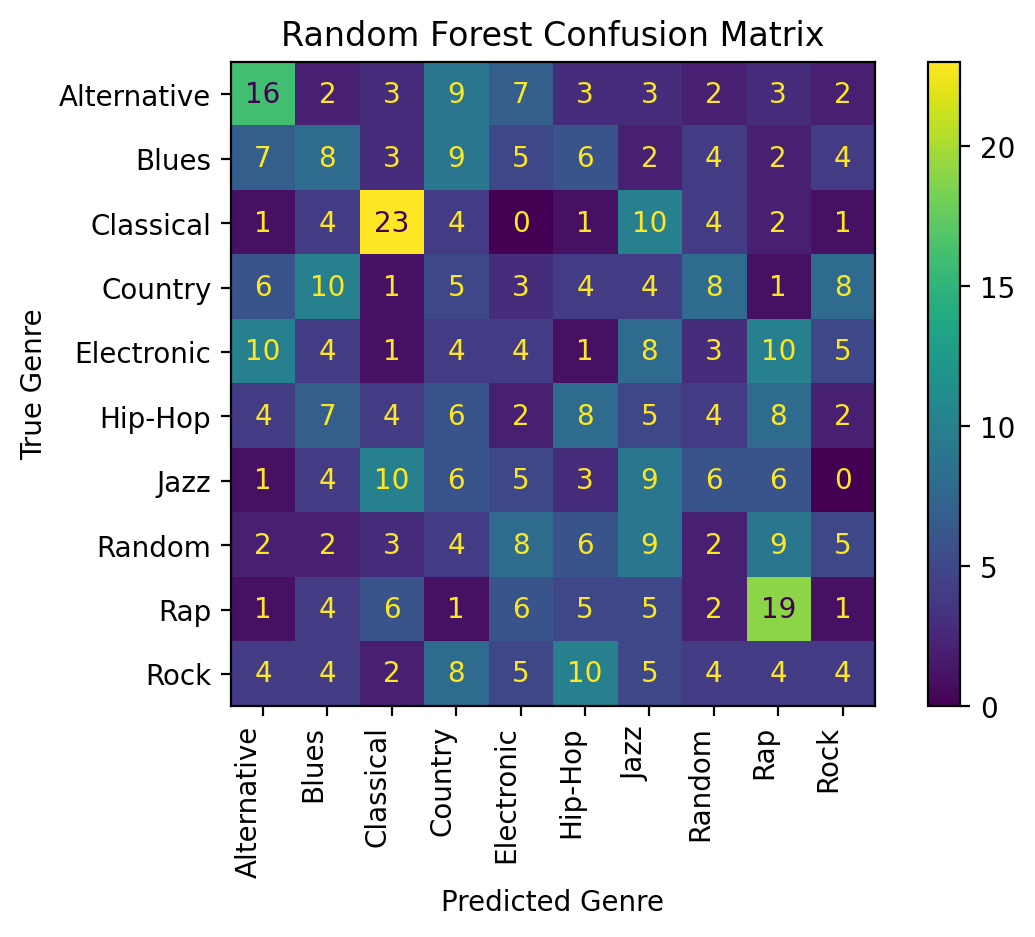

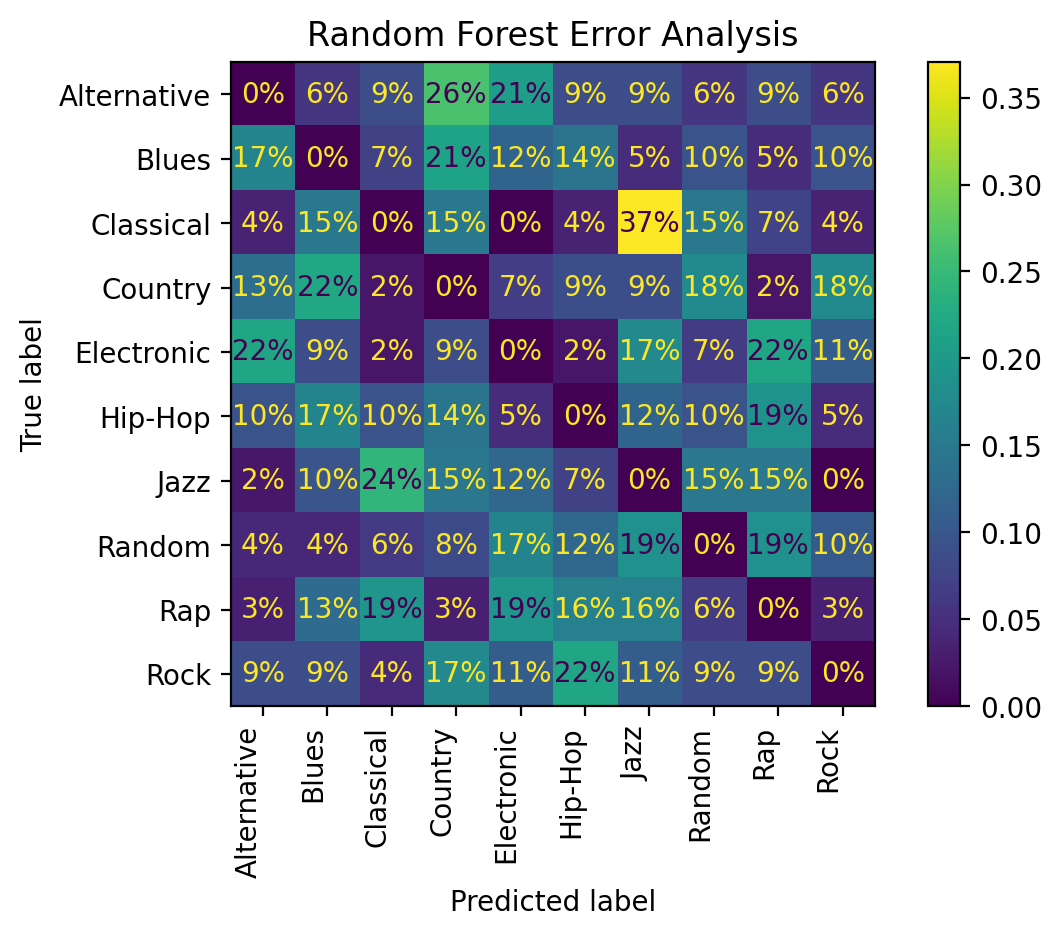

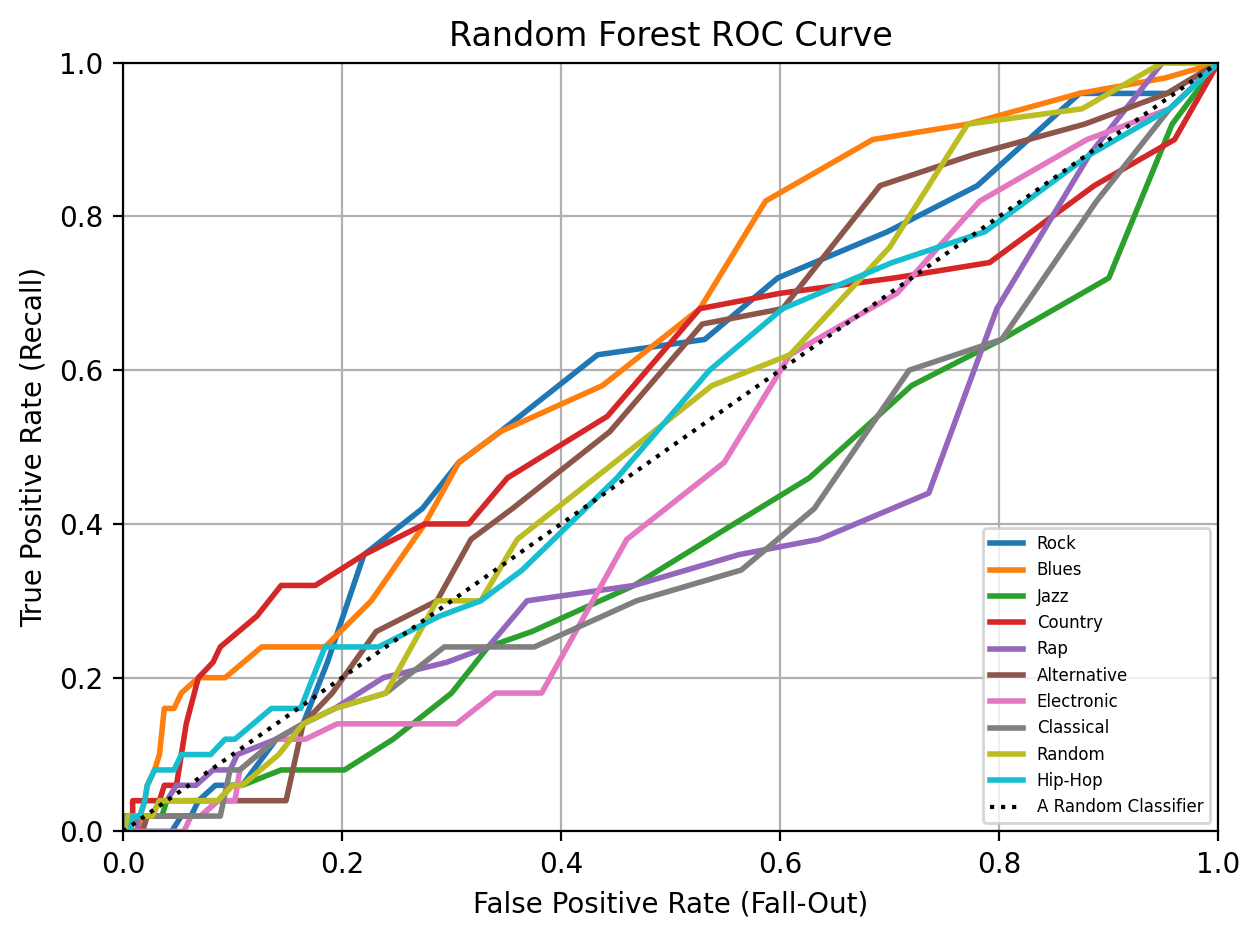

In [25]:
ConfusionMatrixDisplay.from_predictions(y,y_full_pred)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.xticks(rotation=90, ha='right')
save_fig('Random Forest Confusion Matrix')
plt.show()


ConfusionMatrixDisplay.from_predictions(y,y_full_pred,sample_weight= (y_full_pred != y),normalize= 'true',values_format= ".0%")
plt.xticks(rotation=90, ha='right')
# Show the plot
plt.title('Random Forest Error Analysis')
save_fig('Random Forest Error Analysis')
plt.show()


#Do roc curve for each genre
y_scores = cross_val_predict(forest_clf, X_prepared, y, cv=5, method='predict_proba')
y_scores = y_scores[:,1]
fpr, tpr, thresholds = roc_curve(y, y_scores, pos_label='Rock')
plt.plot(fpr, tpr, linewidth=2, label='Rock')
fpr, tpr, thresholds = roc_curve(y, y_scores, pos_label='Blues')
plt.plot(fpr, tpr, linewidth=2, label='Blues')
fpr, tpr, thresholds = roc_curve(y, y_scores, pos_label='Jazz')
plt.plot(fpr, tpr, linewidth=2, label='Jazz')
fpr, tpr, thresholds = roc_curve(y, y_scores, pos_label='Country')
plt.plot(fpr, tpr, linewidth=2, label='Country')
fpr, tpr, thresholds = roc_curve(y, y_scores, pos_label='Rap')
plt.plot(fpr, tpr, linewidth=2, label='Rap')
fpr, tpr, thresholds = roc_curve(y, y_scores, pos_label='Alternative')
plt.plot(fpr, tpr, linewidth=2, label='Alternative')
fpr, tpr, thresholds = roc_curve(y, y_scores, pos_label='Electronic')
plt.plot(fpr, tpr, linewidth=2, label='Electronic')
fpr, tpr, thresholds = roc_curve(y, y_scores, pos_label='Classical')
plt.plot(fpr, tpr, linewidth=2, label='Classical')
fpr, tpr, thresholds = roc_curve(y, y_scores, pos_label='Random')
plt.plot(fpr, tpr, linewidth=2, label='Random')
fpr, tpr, thresholds = roc_curve(y, y_scores, pos_label='Hip-Hop')
plt.plot(fpr, tpr, linewidth=2, label='Hip-Hop')
plt.xlabel('False Positive Rate (Fall-Out)')
plt.plot([0, 1], [0, 1], 'k:', label="A Random Classifier")
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=6)
plt.title('Random Forest ROC Curve')
save_fig('Random Forest ROC Curve')
plt.show()



In [26]:
#From this we can conclude that despite the large number of features added to the dataset,
#the model is still not able to predict the genre of a song with a high accuracy
#This is likely due to the fact that the classification system of genres can be very subjective
#We can easily see that a lot of the genres are very similar to each other and can be easily confused
#This is especially true for the genres like rock, alternative, country, and blues
#Where the songs in these genres can be very similar to each other
#For example, the classification of Nirvana is Alternative, but it can easily be classified as Rock
